# EXTRAVAGANZA ML LAB

## Intro & objective

- Our client, Blockbuster Video, has asked us to **predict whether a customer will be renting a film this month** based on their previous activity and other details.
- They have given access to their relational database for us to extract key data and perform our analysis

## Our process

In order to come up with our predictions we will follow the following process:

1. Extracting key data from de SQL database, resulting in a table containing the following info (which we consider to be crucial to make our predictions:

    - Customer ID
    - City
    -Most rented film category
    -Total films rented
    -Total money spent
    -How many films rented last month (MAY/2005)
    -If the customer rented a movie this month (JUNE/2005) 
    

2. Data Cleaning
3. EDA
4. Feature Scaling
5. Dealing with data imbalance
6. Running the model
7. Evaluating the results
8. Conclusions & key takeaways

# 1. Importing data from SQL database

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # to get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
data1 = pd.read_sql_query('SELECT table_query1.customer_id, city, category, number_of_films_rented, total_money_spent, films_rented_may_2005, question FROM query1 as table_query1 LEFT JOIN query2 as table_query2 on table_query1.customer_id = table_query2.customer_id LEFT JOIN query3 as table_query3 on table_query2.customer_id = table_query3.customer_id LEFT JOIN query4 as table_query4 on table_query1.customer_id = table_query4.customer_id LEFT JOIN query5 as table_query5 on table_query1.customer_id = table_query5.customer_id LEFT JOIN sakila.customer as customer_table on table_query1.customer_id = customer_table.customer_id LEFT JOIN sakila.address as address_table on customer_table.address_id = address_table.address_id LEFT JOIN sakila.city as city_table on address_table.city_id = city_table.city_id;', engine)
data1

,customer_id,city,category,number_of_films_rented,total_money_spent,films_rented_may_2005,question
0,1,Sasebo,Classics,1024,3797.76,64.0,YES
1,2,San Bernardino,Sports,729,3475.71,27.0,YES
2,3,Athenai,Action,676,3529.24,52.0,YES
3,4,Myingyan,Horror,484,1799.16,NaN,YES
4,5,Nantou,Classics,1444,5495.56,114.0,YES
...,...,...,...,...,...,...,...
594,595,Jinzhou,Documentary,900,3531.00,30.0,YES
595,596,Patras,Sports,784,2708.16,168.0,YES
596,597,Sullana,Foreign,625,2493.75,50.0,YES
597,598,Lausanne,Drama,484,1843.16,NaN,YES


# 2. Data cleaning

In [4]:
# Setting customer_id as index

data1 = data1.set_index('customer_id')

In [5]:
# Checking for nulls

data1.isna().sum()

city                       0
category                   0
number_of_films_rented     0
total_money_spent          0
films_rented_may_2005     79
question                   9
dtype: int64

In [6]:
# Filling nulls

data1["question"].fillna("NO", inplace = True) 

In [7]:
data1["films_rented_may_2005"].fillna(0, inplace = True) 

In [8]:
# Making sure that I do not have any more nulls

data1.isna().sum()

city                      0
category                  0
number_of_films_rented    0
total_money_spent         0
films_rented_may_2005     0
question                  0
dtype: int64

In [9]:
data1.dtypes

city                       object
category                   object
number_of_films_rented      int64
total_money_spent         float64
films_rented_may_2005     float64
question                   object
dtype: object

In [10]:
# Changing films_rented_may_2005 data type to integer. 

data1["films_rented_may_2005"] = data1["films_rented_may_2005"].apply(lambda x: int((float(x))))

In [11]:
data1.dtypes

city                       object
category                   object
number_of_films_rented      int64
total_money_spent         float64
films_rented_may_2005       int64
question                   object
dtype: object

In [12]:
import numpy as np

In [13]:
# Separating numerical & categorical values

data_num = data1.select_dtypes(np.number)
data_cat = data1.select_dtypes(np.object)

In [14]:
for col in data1.select_dtypes('object'):
    print(data1[col].value_counts(), '\n')

London         2
Aurora         2
Baha Blanca    1
Wroclaw        1
Faaa           1
              ..
Abha           1
Boksburg       1
Jos Azueta     1
So Leopoldo    1
Niznekamsk     1
Name: city, Length: 597, dtype: int64 

Sports         62
Sci-Fi         59
Animation      57
Documentary    49
Action         43
Family         39
Foreign        39
New            39
Drama          36
Games          33
Classics       31
Comedy         23
Travel         23
Children       23
Horror         22
Music          21
Name: category, dtype: int64 

YES    590
NO       9
Name: question, dtype: int64 



# 3. EDA

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Customers rented an average of 53.28714524207012 films last month


<AxesSubplot:>

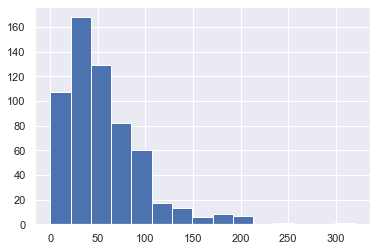

In [16]:
films_rented_may_2005 = data1['films_rented_may_2005'].mean()
print("Customers rented an average of",films_rented_may_2005,"films last month")

sns.set()
data1['films_rented_may_2005'].hist(bins = 15)

Surprisingly, the most rented category was Sports, followed by Sci-Fi & Animation


<AxesSubplot:>

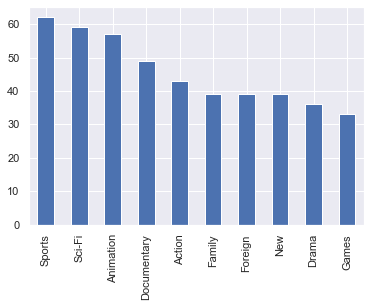

In [17]:
# In the following graph we can see which are the most rented categories overall

print("Surprisingly, the most rented category was Sports, followed by Sci-Fi & Animation")
data1['category'].value_counts().head(10).plot.bar()

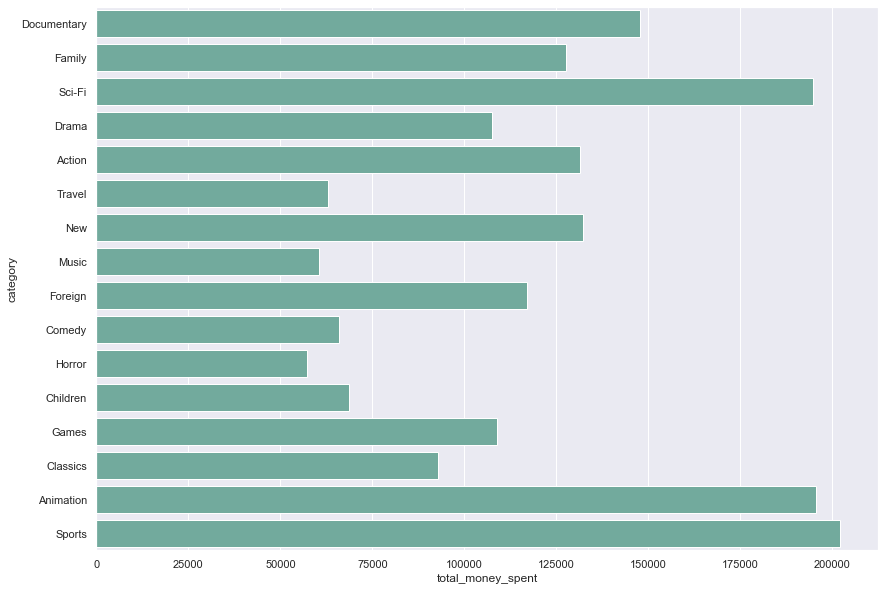

In [18]:
# Here we can see the relation between the variables 'category' & 'total money spent', given the results we can assume that the films will most likely have the same price despite its category, as the graph resembles the previous one...

plt.figure(figsize=(14, 10))

# Reorder this data frame - this doesn't work :S...

data1 = data1.sort_values('total_money_spent').reset_index()

sns.barplot(
    x="total_money_spent", 
    y="category", 
    data=data1, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

In [19]:
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='customer_id', ylabel='number_of_films_rented'>

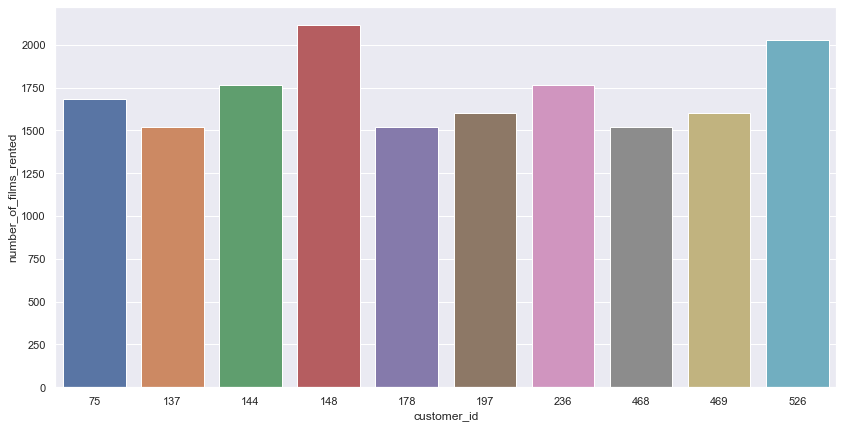

In [20]:
# Top 10 customers (which rented the most number of films overall)

top_rented = data1.sort_values(by=["number_of_films_rented"], ascending=False)
top_rented.head(10)

plt.figure(figsize=(14, 7))
sns.barplot(top_rented['customer_id'].head(10), top_rented['number_of_films_rented'].head(10))

Almost all the customers rented a movie last month


<AxesSubplot:>

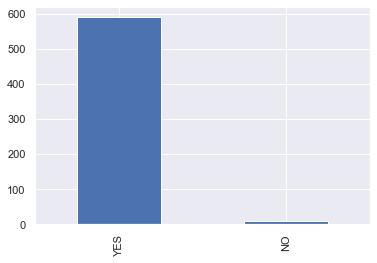

In [21]:
# In the following graph we can see how many customers rented a film last month...

print("Almost all the customers rented a movie last month")
data1['question'].value_counts().head(10).plot.bar()

In [22]:
data1.describe()

,customer_id,number_of_films_rented,total_money_spent,films_rented_may_2005
count,599.000000,599.000000,599.000000,599.000000
mean,300.000000,743.831386,3127.713606,53.287145
std,173.060683,283.229813,1274.733932,43.397876
min,1.000000,144.000000,634.560000,0.000000
25%,150.500000,529.000000,2232.700000,25.000000
50%,300.000000,676.000000,2943.750000,46.000000
75%,449.500000,900.000000,3800.580000,70.000000
max,599.000000,2116.000000,9969.750000,320.000000


In [23]:
# checking data correlations

data_corr = data1.corr(method='spearman')
data_corr

,customer_id,number_of_films_rented,total_money_spent,films_rented_may_2005
customer_id,1.000000,-0.093056,-0.067675,-0.076816
number_of_films_rented,-0.093056,1.000000,0.957159,0.424372
total_money_spent,-0.067675,0.957159,1.000000,0.411350
films_rented_may_2005,-0.076816,0.424372,0.411350,1.000000


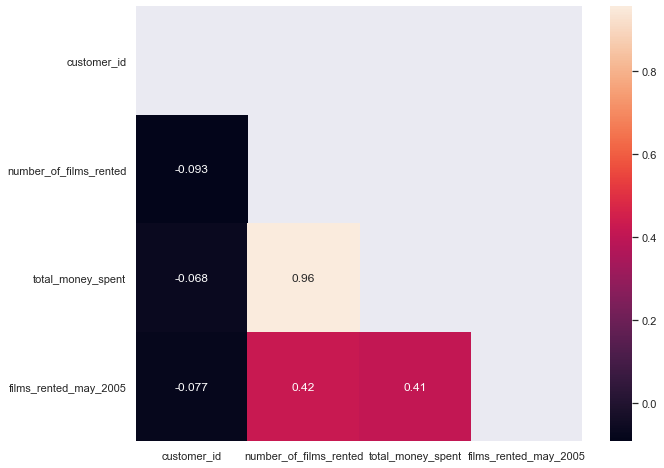

In [24]:
mask = np.zeros_like(data_corr)

mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(data_corr, mask=mask, annot=True)
plt.show()

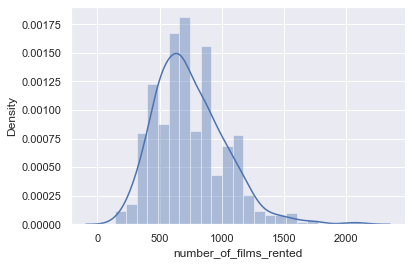

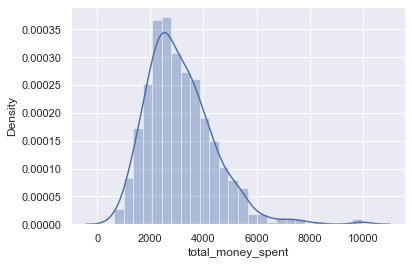

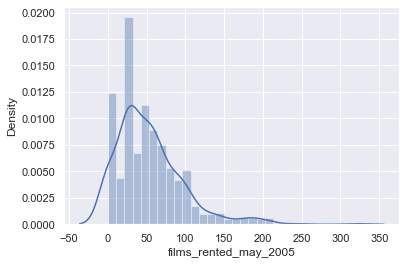

In [25]:
# Checkig the distribution for numerical columns

for column in data_num.columns:
    sns.distplot(data_num[column])
    plt.show()

# 4. Feature Scaling

In [26]:
# We apply a BoxCox transformation to normalize our distributions

from scipy import stats

def boxcox_transform(data1):
    numeric_cols = data1.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        data1[column] = np.where(data1[column]<=0, np.NAN, data1[column]) 
        data1[column] = data1[column].fillna(data1[column].mean())
        transformed_data, ci = stats.boxcox(data1[column])
        data1[column] = transformed_data
        _ci[column] = ci
    return data1, _ci

In [27]:
data1, _ci = boxcox_transform(data1)

# 5. Solving data imbalance

In [28]:
# We proceed to drop city column as the values are really disperse and they add no value to our model (many cities,mostly only one customer per city)

data1 = data1.drop('city', axis=1)

In [29]:
data2 = data1=pd.get_dummies(data1,columns=['category'])
data2

,customer_id,number_of_films_rented,total_money_spent,films_rented_may_2005,question,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,82.961381,11.486502,14.268411,2.326146,YES,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,75.864120,12.924313,14.751795,3.050908,YES,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,69.302121,13.612255,15.046366,3.108483,YES,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,24.700194,12.924313,15.382668,2.460471,NO,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,38.281626,12.924313,15.456736,3.050908,YES,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,54.460223,26.751729,27.950117,3.693500,YES,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
595,44.978921,26.751729,27.950117,3.325489,YES,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
596,46.650414,28.121469,28.521023,3.942822,YES,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
597,47.594964,29.888473,29.955143,3.460469,YES,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
# SMOTE - we use an upsampling method as the data base is too small and we do not want to lose too much info.
# I drop the target variable but also total_money_spent as it had a really high correlation with number of films...

from imblearn.over_sampling import SMOTE

smote = SMOTE()

X = data2.drop(['question','total_money_spent'], axis = 1) 
y = data2['question']

X,y = smote.fit_resample(X, y)
y.value_counts()

NO     590
YES    590
Name: question, dtype: int64

# 6. Running the model

In [35]:
# Train / Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# We train the model

from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

# 7. Evaluating the model

In [37]:
classification.score(X_test, y_test)

0.9915254237288136

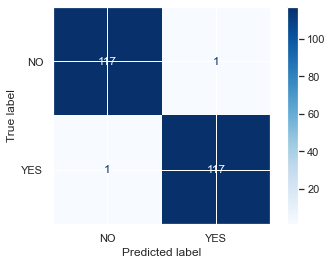

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

In [39]:
from sklearn import metrics

predictions = classification.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          NO       0.99      0.99      0.99       118
         YES       0.99      0.99      0.99       118

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236



# 8. Conclusions & Key Takeaways

- We have developed a model that can accurately predict (0.99 in accuracy) the likelyhood of a customer renting a movie next month
- We have accomplished the same high fi-score for both options (YES/NO) meaning that the model will be able to predict both outcomes with the same accuracy
- We have acknowledged the importance of dealing with data imbalance in a dataset that was particularly "biased" towards one option (in this case the vast majority of customers had rented a movie last month)
- Having normilised the data distributions leveraging box-cox transformation has also helped us to get a more accurate model